## Simple Movie Recommendation System
    - Team Members: 
        Khaled Al Butainy
        Abdul Jawad Mohammed


In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
import plotly.express as px
filterwarnings('ignore')

## I. INTRODUCTION

Like any form of art, movies produce subjective experiences for different types of people. Every  movie caters  towards  certain demographics  due  to  its  genre,  style,  and  themes.  With thousands of movies releasing every year, users are flooded with an enormous number of choices to pick from. While this may initially be seen as a blessing, having too many choices on what to spend time on can drive away customers. It is difficult for one to know which movies they may like or dislike, and if it is worth spending their time on. With this problem in mind, we experimented with developing a user-specific movie recommendation system that primarily uses average genre ratings and overall user ratings to predict the user-given scores for unseen movies. 

### **a. Dataset Information**
MovieLens Dataset: Compiled by the GroupLens Research Organization, the MovieLens Dataset consists of ratings of over 62,000 movies generated by 16,000 users from 1995 to 2019. Each user has at least 20 movies watched. 

### b. Implementation Plan
- In order to create a simple movie recommendation system using Machine learning techniques:
    1. We generate a dataset specific to a user with our constructed features representing the average ratings of each genre of a movie. The dataset will consist of all the movies watched by the user AND unseen movies.
    2. We perform a grid search for each classifier on a dataset of ONLY SEEN movies, and have their performances recorded.
    3. After each classifier grid search, the version with the best hyperparameters is evaluated on a test set (split from SEEN movies in order to have metrics)
    4. The best model out of ALL the classifiers is then used to generate a list of predicted ratings on the dataset of UNSEEN movies, where the top 10 (considering both ratings and total popularity) are shown.

## II. Dataset Preparation
Separated into multiple csv files, the MovieLens dataset was daunting to preprocess. It was split into the following files:

1. tag.csv: Containing user-applied tags associated with movies
2. rating.csv: Containing user ratings for movies
3. movie.csv: Containing movie information (name, id, genre, etc.).
4. link.csv: identifiers/extra website links.
5. genome_scores.csv: Contains how relevant the tags are with each movie.
6. genome_tags.csv: Contains descriptions of the tags.

### a. Feature Construction
With the dataset's huge number of features of various data types, we decided to construct our own features in order to be able to handle a project within our currrent scope. Cells 2-9 consist of column eliminations, merges, and column additions in order to create a dataset with our custom features.

In [2]:
## Loading the first dataset (MovieLens Dataset)
root1 = "ml-25m/"
genome_s = pd.read_csv(root1+"genome-scores.csv")
genome_t = pd.read_csv(root1+"genome-tags.csv")
links1 = pd.read_csv(root1+"links.csv")
movies1 = pd.read_csv(root1+"movies.csv")
ratings1 = pd.read_csv(root1+"ratings.csv")
tags = pd.read_csv(root1+"tags.csv")

In [3]:
# Merging the first dataset (MovieLens dataset)
ML_dataset = pd.merge(ratings1, movies1, left_on='movieId', right_on='movieId', how='left')
is_no_genre = ML_dataset['genres']!='(no genres listed)'
ML_dataset = ML_dataset[is_no_genre].dropna()

### b. The original Dataset's row count was around 25 million.

In [4]:
ML_dataset.info(show_counts=True)
ML_dataset.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24973468 entries, 0 to 25000094
Data columns (total 6 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     24973468 non-null  int64  
 1   movieId    24973468 non-null  int64  
 2   rating     24973468 non-null  float64
 3   timestamp  24973468 non-null  int64  
 4   title      24973468 non-null  object 
 5   genres     24973468 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.3+ GB


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama


### c. Observation of the number of ratings per movie.
    - Can be considered to be the total number of users who watched a movie.
    - A good popularity indicator
    - Some movies only had a handful of users who watched it.

In [5]:
movieIdCount = pd.DataFrame(ML_dataset.groupby('movieId').size().reset_index(name='tot_ratings'))
userIdCount = pd.DataFrame(ML_dataset.groupby('userId').size().reset_index(name='tot_ratings')).sort_values(by="tot_ratings")
print(movieIdCount.head(3))
print(userIdCount.head(3))
print(userIdCount.tail(3))

   movieId  tot_ratings
0        1        57309
1        2        24228
2        3        11804
        userId  tot_ratings
149502  149503           18
81033    81034           18
103147  103148           19
        userId  tot_ratings
137292  137293         8814
80973    80974         9176
72314    72315        30271


In [6]:
# List of all unique genres
genres = pd.DataFrame(ML_dataset.groupby('genres'), columns=['genres', 'other'])
if 'other' in  genres.columns: del genres['other']
unique_genres = []
for g in range(len(genres)):
    gens = genres['genres'].iloc[g].split('|')
    for gen in gens:
        if gen not in unique_genres:
            unique_genres.append(gen)

unique_genres = pd.DataFrame(unique_genres, columns=['genres'])

In [7]:
movieDF = movieIdCount.copy()
movieSumRating = pd.DataFrame(ML_dataset.groupby('movieId').sum())
if 'userId' in movieSumRating.columns: del movieSumRating['userId']
if 'timestamp' in movieSumRating.columns: del movieSumRating['timestamp']
movieDF = pd.merge(movieDF, movieSumRating, left_on='movieId', right_on='movieId', how='left')
if "avg_rating" not in movieDF.columns: 
    movieDF["avg_rating"] = movieDF['rating']/movieDF['tot_ratings']
if 'tot_ratings' in movieDF.columns: del movieDF['tot_ratings']
if 'rating' in movieDF.columns: del movieDF['rating']

ML_ds_copy = ML_dataset.copy()
if 'userId' in ML_ds_copy.columns: del ML_ds_copy['userId']
if 'title' in ML_ds_copy.columns: del ML_ds_copy['title']
if 'rating' in ML_ds_copy.columns: del ML_ds_copy['rating']
if 'timestamp' in ML_ds_copy.columns: del ML_ds_copy['timestamp']
ML_ds_copy = ML_ds_copy.drop_duplicates(subset=['movieId'])
movieDF = pd.merge(movieDF, ML_ds_copy, left_on='movieId', right_on='movieId', how='left')

for gen in range(len(unique_genres)):
    movieDF[unique_genres['genres'].iloc[gen]] = np.zeros(len(movieDF))


### d. Generation of the user-specific dataset
- The end of the dataset preparation process resulted in a dataset containing all movies watched by the user. 
- The ratings per each genre indicate how much the movie excels according to its genre. Ex: 'Is Toy Story a good Children's movie? Is it also funny enough to be a good comedy movie?'
- However, without normalization, they do not tell much yet as its just the total rating copied over multiple times.

In [8]:
for row in range(len(movieDF)):
    genreList = movieDF['genres'].iloc[row].split('|')
    for genre in genreList:
        if str(genre) in list(movieDF):
            movieDF[str(genre)].iloc[row] = round(movieDF['avg_rating'].iloc[row],2)

movieDF = movieDF.drop_duplicates(subset=['movieId'])
movieDF.head()

,movieId,avg_rating,genres,Action,Adventure,Animation,Children,Comedy,Fantasy,IMAX,...,Western,Crime,Mystery,Drama,Thriller,War,Horror,Film-Noir,Documentary,Musical
0,1,3.893708,Adventure|Animation|Children|Comedy|Fantasy,0.0,3.89,3.89,3.89,3.89,3.89,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,2,3.251527,Adventure|Children|Fantasy,0.0,3.25,0.00,3.25,0.00,3.25,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,3,3.142028,Comedy|Romance,0.0,0.00,0.00,0.00,3.14,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2.853547,Comedy|Drama|Romance,0.0,0.00,0.00,0.00,2.85,0.00,0.0,...,0.0,0.0,0.0,2.85,0.0,0.0,0.0,0.0,0.0,0.0
4,5,3.058434,Comedy,0.0,0.00,0.00,0.00,3.06,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


### e. Sample Thresholding
- With some users having only watched 5 to 10 movies, we thought of setting a minimum threshold when a user is selected in order to have an adequate sample size.
- If threshold is 100 samples and the chosen user only has 10, then we randomly keep taking samples from the unseen movies that share the same genre of the highest-rated movies by the user, with the average rating copied to each of them.

In [9]:
def set_user_ratings(userID, ML_dataset, movieIdCount, threshold = None):
    '''
    called before split_ratings (which devides the dataset into seen and unseen movies based on Nan values)
    takes userID, ML_dataset, movieIdCount, and optional threshold as arguments
    returns user_data_y, user_data (user_data_y: labels for user ratings, user_data: more detailed user data to be used in analysis)
    '''

    user_data = ML_dataset.loc[ML_dataset['userId'] == userID]
    user_data["truly_watched"] = np.ones(len(user_data)).astype(int)

    if threshold != None and len(user_data) < threshold and not len(user_data) == 0:
        watched_genres = user_data["genres"].copy()
        i = 0
        while len(user_data) < threshold:
            unrated = ML_dataset.loc[ML_dataset['genres'] == watched_genres.iloc[i]].loc[ML_dataset['userId'] != userID]
            random_idx = np.random.randint(0, len(unrated))
            if unrated['movieId'].iloc[random_idx] not in user_data['movieId']:
                newRating = pd.DataFrame([[userID,
                                        unrated['movieId'].iloc[random_idx],
                                        user_data['rating'].iloc[i],
                                        unrated['timestamp'].iloc[random_idx],
                                        unrated['title'].iloc[random_idx],
                                        unrated['genres'].iloc[random_idx],
                                        0]], columns=user_data.columns)          
                user_data = user_data.append(newRating, ignore_index=True)
                user_data = user_data.drop_duplicates(subset=["movieId"])
                
            i += 1
            i %= len(watched_genres)  

    user_data_y = pd.merge(user_data, movieIdCount, left_on='movieId', right_on='movieId', how="right")
    user_data_y.drop(['userId', 'timestamp', 'title', 'genres', 'tot_ratings', 'truly_watched'], axis=1, inplace=True)
    return user_data_y, user_data

def split_ratings(user_data, movieDF):
    '''
    takes user_data_y, movieDF as arguments
    return seen_movies_X (to be used in training), seen_movies_Y, unseen_movies (to be used as a real-world examples after the model is ready) 
    '''

    user_data_y['rating'] = user_data_y["rating"].fillna(-1)
    merged = pd.merge(user_data_y, movieDF, left_on="movieId", right_on="movieId")
    seen_movies_X = merged.loc[merged['rating'] != -1]
    unseen_movies = merged.loc[merged['rating'] == -1]
    seen_movies_Y = user_data_y.loc[user_data_y['rating'] != -1]
    del unseen_movies['rating']
    del seen_movies_X['rating']
    
    return seen_movies_X, seen_movies_Y, unseen_movies


    #avgRating/genre


### User Selection
- For experimental purposes and for the rest of this report, we analyzed three users who had varying amounts of movies watched. In the cell below, userid 72315 was selected for the training due to having watched over 30,000 movies.

In [10]:
userID = [81034, 80974, 72315]
threshold = 150 #this will take a long time for low number of samples

set_ratings = set_user_ratings(userID[2], ML_dataset, movieIdCount, threshold=threshold)
user_data_y = set_ratings[0]
user_data = set_ratings[1]

## III. Data Analysis
- For the labels, we converted the average rating of each movie into categorical values: '0.5', '1.0'..... '5'
- We wanted to first analyze frequency of the user's positive/negative/mediocre ratings for each movie.
- The barplot below shows the number of movies under each rating (according to only the user)

- The user's average seems to be middling, between 3.0 and 3.5, which means he either watches generally well-liked movies or is quite easy to please.

Text(0.5, 1.0, 'Movies/Rating Category')

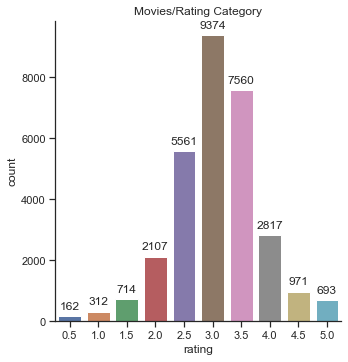

In [11]:
sns.set_theme(style="ticks", color_codes=True)
ratings_summary = user_data.groupby(user_data['rating']).size().reset_index(name="count")
g = sns.catplot(x="rating", y="count", data=ratings_summary, kind="bar")

for ax in g.axes.ravel():
  for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10),
                textcoords = 'offset points')

    
plt.title("Movies/Rating Category")

In [60]:
split = split_ratings(user_data_y, movieDF)
X = split[0]
Y = split[1]

X.drop(['movieId', 'genres', 'avg_rating'], inplace = True, axis = 1)
Y.drop(['movieId'], axis = 1, inplace = True)

In [15]:
X_copy = X.copy()
genres_count = unique_genres.copy()
genres_count["count"] = np.zeros(len(genres_count)).astype(int)
for gen in range(len(unique_genres)):
    count = X_copy.groupby(unique_genres.iloc[gen].iloc[0]).size().reset_index(name="count")
    genres_count['count'].iloc[gen] = len(X) - count["count"].iloc[0]

### Analyzing Number of Movies per Genre
- The plot below seems to indicate that the user mostly watches movies of the drama genre. 
- A huge imbalance is observed between the drama class and the rest of the dataset.

Text(0.5, 1.0, 'Movies/Genre')

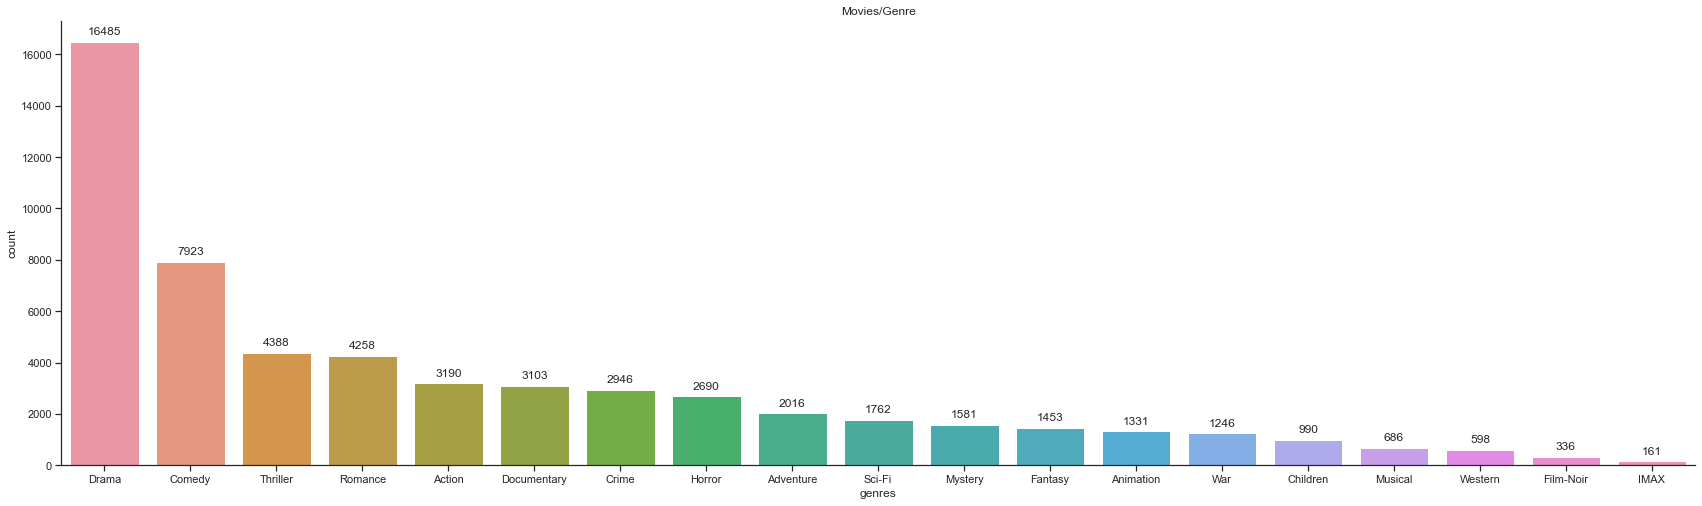

In [16]:
g = sns.catplot(data = genres_count.sort_values(by=['count'], ascending=False),
            x = 'genres', y = 'count', kind = 'bar',
               height = 7, aspect = 3.4)

for ax in g.axes.ravel():
  for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10),
                textcoords = 'offset points')

plt.title("Movies/Genre")

In [17]:
Y_copy = Y.copy()
X_copy = X.copy()
genres_rating = pd.DataFrame(columns = ["movieId", "rating", "genre"])
for gen in range(len(unique_genres)):
    usr_ratings = Y_copy.loc[X_copy[unique_genres.iloc[gen].iloc[0]] != 0]
    usr_ratings["genre"] = ((unique_genres.iloc[gen].iloc[0]+" ")*len(usr_ratings)).split(" ")[:-1]
    genres_rating = genres_rating.append(usr_ratings)

### BoxPlot Analysis
- The boxplot indicates that the user has rated atleast 1 movie from multiple genres a 5-star. The only genres with 5 star ratings are Animation, IMAX, Horror, War, and Film-noir.
- The averages (represented by the green triangles) indicate an average of approximately 3

Text(0.5, 1.0, 'Rating/Genre')

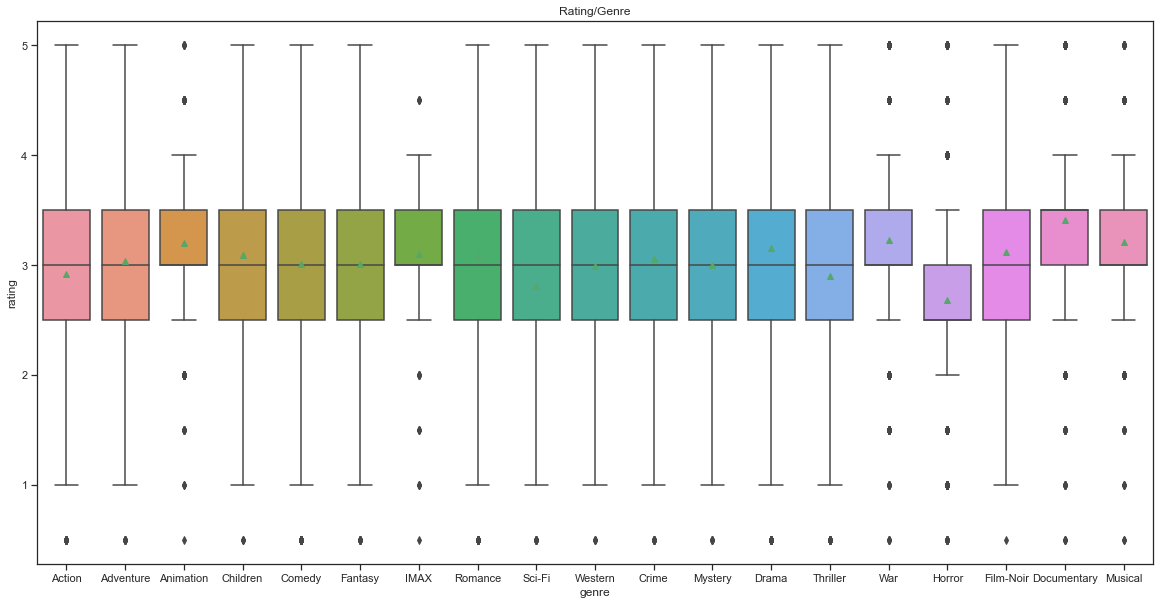

In [46]:
plt.figure(figsize=(20, 10))
g = sns.boxplot(data = genres_rating, x = 'genre', y = 'rating',
                 showmeans=True)
plt.title("Rating/Genre")

### Correlation Matrix
- To gauge the correlations with the constructed features, we created a correlarion matrix.
- The feaures seem to be mostly unrelated to each other, but certain genres comparitively have a weak yet observable relationship.
- A weak link between Animation and Children (with corr: 0.35) suggests that the user has watched many movies containing both these genres. The same can be said for Thriller, Mystery, and Crime (0.26).

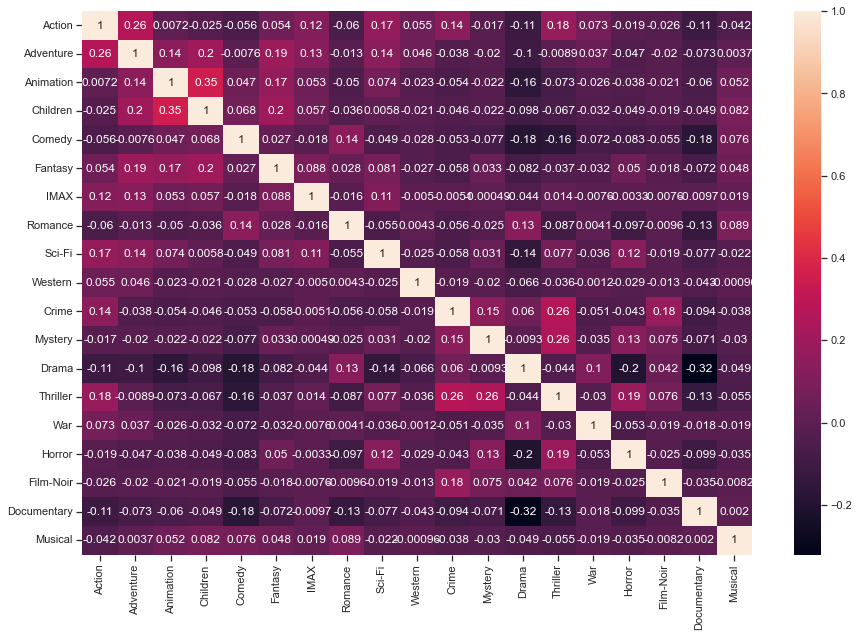

In [44]:
plt.figure(figsize=(15, 10))
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

## IV. Fitting Classifiers
- For classification, we plan to use the following learning algorithms:
    - SVM
    - Log Regression
    - Gaussian Matrix (Expectation-Maximization)
    - Ensemble Learning (random forests, etc.)
   

In [19]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures
import itertools

In [20]:
unique_classes = sorted(Y['rating'].unique())
print("num classes: ", len(unique_classes))
print(unique_classes)

num classes:  10
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### III. a. Splitting and Normalization of Data
- Normalizing the average ratings using minmax gives us an idea of how much a movie excels in each of its respective genres when compared to the best movies in those said genres.

- The SEEN movies is used to for training. A 70-15-15 split is applied for training, validation, and testing.

In [21]:
X_data = X.to_numpy()

x_train, x_val_test, y_train, y_val_test = train_test_split(X_data, Y.astype(str), test_size = 0.3 )
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5)


scaler = MinMaxScaler().fit(x_train)
x_trainScaled = scaler.transform(x_train)
x_valScaled = scaler.transform(x_val)
x_testScaled = scaler.transform(x_test)

### b. Logistic Regression

- The logistic regression classifier, being a common classifier for both multiclass and binary classification, was chosen due to its strong probability prediction capabilities.
- We decided to tune the C value, or the inverse regularization strength. 
- Due to a huge imbalance in data, the classifier was not able to classify other categories, and only correctly classified those of 3-3.5 rating categories.
- Changing the C value did not amount to much net change in validation Accuracy

In [23]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
best_acc = 0
best_cost = 0
best_log_model = None
for c in Cs:
    clf1 = LogisticRegression(C = c, solver="saga", random_state = 777)
    logModel = clf1.fit(x_trainScaled, y_train)
    y_pred_train = logModel.predict(x_trainScaled)
    y_pred_val   = logModel.predict(x_valScaled)
    Train_acc = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    Val_acc = accuracy_score(y_true = y_val, y_pred = y_pred_val)
    print(f'Training accuracy: {Train_acc*100:.2f}%', end = " ")
    print(f'Validation accuracy: {Val_acc*100:.2f}% C: {c}')
    if Val_acc>best_acc:
        best_log_model = logModel
        best_acc = Val_acc
        best_cost = c
        
print(f'\nBest Performance on Validation Set: {best_acc*100:.2f}%, Best C Value: {best_cost}')

y_pred_test = best_log_model.predict(x_testScaled)
Test_acc = accuracy_score(y_true = y_test, y_pred = y_pred_test)
print(f'\nTest accuracy of Best model: {Test_acc*100:.2f}%')

Training accuracy: 31.58% Validation accuracy: 31.27% C: 0.001
Training accuracy: 33.74% Validation accuracy: 33.05% C: 0.01
Training accuracy: 34.79% Validation accuracy: 34.44% C: 0.1
Training accuracy: 34.29% Validation accuracy: 34.31% C: 1
Training accuracy: 34.22% Validation accuracy: 34.29% C: 10
Training accuracy: 34.23% Validation accuracy: 34.29% C: 100
Training accuracy: 34.22% Validation accuracy: 34.29% C: 1000

Best Performance on Validation Set: 34.44%, Best C Value: 0.1

Test accuracy of Best model: 32.46%


### Confusion Matrices and Classification Reports

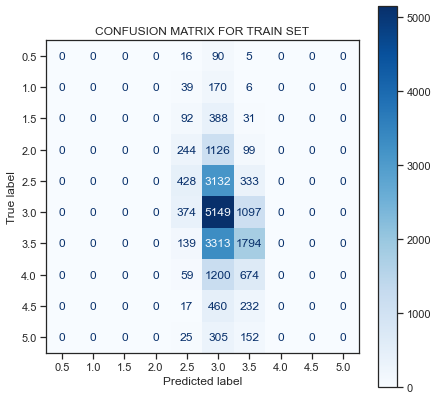

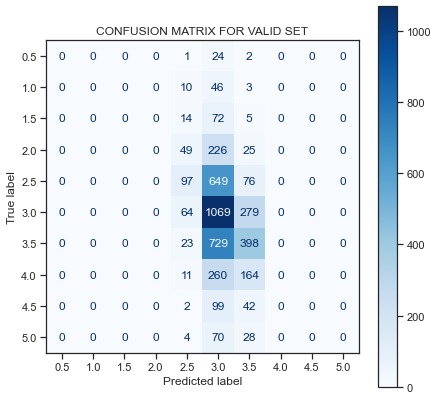

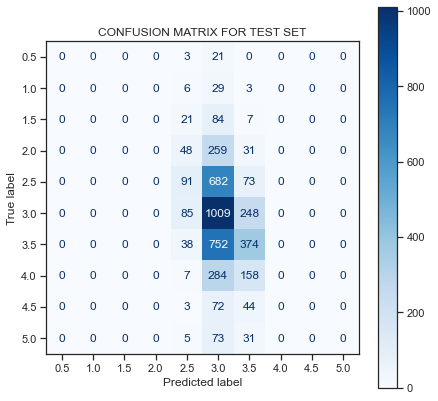

In [24]:
labels = unique_classes

featureSet     = [x_trainScaled, x_valScaled, x_testScaled]
labelSet       = [y_train, y_val, y_test]
typeOfTraining = ['TRAIN SET', 'VALID SET', 'TEST SET']


for i in range(len(featureSet)):
    y_pred = best_log_model.predict(featureSet[i])
    cm = confusion_matrix(labelSet[i], y_pred)

    fig, ax = plt.subplots(figsize = (7,7))

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = plt.cm.Blues, ax=ax)
    plt.title(f'CONFUSION MATRIX FOR {typeOfTraining[i]}')
    plt.show()

In [25]:
for i in range(len(featureSet)):
    y_pred = best_log_model.predict(featureSet[i])
    print(f'{typeOfTraining[i]} Set: \n')
    print(classification_report(labelSet[i], y_pred))

TRAIN SET Set: 

              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00       111
         1.0       0.00      0.00      0.00       215
         1.5       0.00      0.00      0.00       511
         2.0       0.00      0.00      0.00      1469
         2.5       0.30      0.11      0.16      3893
         3.0       0.34      0.78      0.47      6620
         3.5       0.41      0.34      0.37      5246
         4.0       0.00      0.00      0.00      1933
         4.5       0.00      0.00      0.00       709
         5.0       0.00      0.00      0.00       482

    accuracy                           0.35     21189
   macro avg       0.10      0.12      0.10     21189
weighted avg       0.26      0.35      0.27     21189

VALID SET Set: 

              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00        27
         1.0       0.00      0.00      0.00        59
         1.5       0.00      0.00      0.00 

### III. b. i Using 'class_weight' Feature in sklearn's LogisticRegression Classifier
- Oberving the imbalance in the dataset, we decided to try out the 'class_weights' argument of the LogRegressionClassifier, which assigns weights to classes not being paid enough attention to.
- Unfortunately, the overall accuracy was observed to be worse than before, falling to about 10-15%.
- HOWEVER, the classifier was able to detect samples from more classes, resulting in a higher precision, recall, and f-score than without class weights.

In [26]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

best_acc = 0
best_cost = 0
best_logw_model = None
for c in Cs:
    clf1 = LogisticRegression(C = c, solver="saga", class_weight = 'balanced', random_state = 777)
    logModel = clf1.fit(x_trainScaled, y_train)
    y_pred_train = logModel.predict(x_trainScaled)
    y_pred_val   = logModel.predict(x_valScaled)
    Train_acc = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    Val_acc = accuracy_score(y_true = y_val, y_pred = y_pred_val)
    print(f'Training accuracy: {Train_acc*100:.2f}%', end = " ")
    print(f'Validation accuracy: {Val_acc*100:.2f}% C: {c}')
    if Val_acc>best_acc:
        best_logw_model = logModel
        best_acc = Val_acc
        best_cost = c
        
print(f'\nBest Performance on Validation Set: {best_acc*100}%, Best C Value: {best_cost}')

y_pred_test = best_logw_model.predict(x_testScaled)
Test_acc = accuracy_score(y_true = y_test, y_pred = y_pred_test)
print(f'\nTest accuracy of Best model: {Test_acc*100:.2f}%')

Training accuracy: 10.62% Validation accuracy: 10.50% C: 0.001
Training accuracy: 12.57% Validation accuracy: 12.44% C: 0.01
Training accuracy: 13.89% Validation accuracy: 13.79% C: 0.1
Training accuracy: 14.14% Validation accuracy: 13.83% C: 1
Training accuracy: 14.10% Validation accuracy: 13.79% C: 10
Training accuracy: 14.07% Validation accuracy: 13.76% C: 100
Training accuracy: 14.07% Validation accuracy: 13.76% C: 1000

Best Performance on Validation Set: 13.829552961902664%, Best C Value: 1

Test accuracy of Best model: 14.18%


### Confusion Matrices and Classification Reports

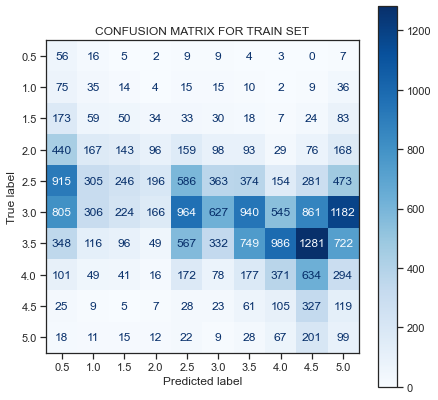

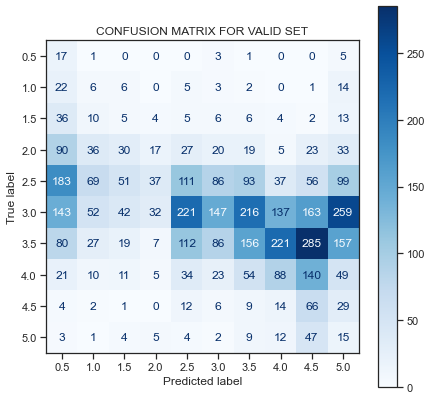

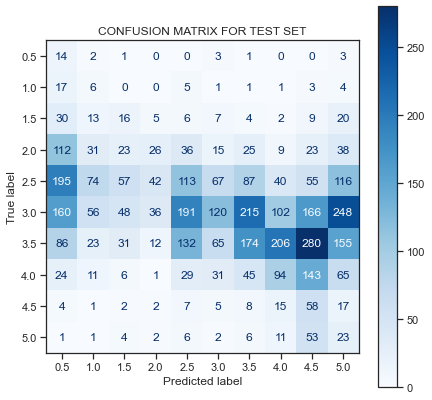

In [27]:
labels = unique_classes

featureSet     = [x_trainScaled, x_valScaled, x_testScaled]
labelSet       = [y_train, y_val, y_test]
typeOfTraining = ['TRAIN SET', 'VALID SET', 'TEST SET']


for i in range(len(featureSet)):
    y_pred = best_logw_model.predict(featureSet[i])
    cm = confusion_matrix(labelSet[i], y_pred)

    fig, ax = plt.subplots(figsize = (7,7))

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = plt.cm.Blues, ax=ax)
    plt.title(f'CONFUSION MATRIX FOR {typeOfTraining[i]}')
    plt.show()

In [28]:
for i in range(len(featureSet)):
    y_pred = best_logw_model.predict(featureSet[i])
    print(f'{typeOfTraining[i]} Set: \n')
    print(classification_report(labelSet[i], y_pred))

TRAIN SET Set: 

              precision    recall  f1-score   support

         0.5       0.02      0.50      0.04       111
         1.0       0.03      0.16      0.05       215
         1.5       0.06      0.10      0.07       511
         2.0       0.16      0.07      0.09      1469
         2.5       0.23      0.15      0.18      3893
         3.0       0.40      0.09      0.15      6620
         3.5       0.31      0.14      0.19      5246
         4.0       0.16      0.19      0.18      1933
         4.5       0.09      0.46      0.15       709
         5.0       0.03      0.21      0.05       482

    accuracy                           0.14     21189
   macro avg       0.15      0.21      0.12     21189
weighted avg       0.27      0.14      0.16     21189

VALID SET Set: 

              precision    recall  f1-score   support

         0.5       0.03      0.63      0.05        27
         1.0       0.03      0.10      0.04        59
         1.5       0.03      0.05      0.04 

### III. c. SVM Classifier

In [29]:
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
degList = [2,3,4]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_acc = 0
best_degree = 0
best_kernel = ''
best_cost = 0
best_SVM_model = None

for k in kernels:
    if k == 'poly':
        for deg in degList:
            clf2 = SVC(kernel = k, degree = deg, random_state = 777)
            svmModel = clf2.fit(x_trainScaled, y_train)
            
            y_pred_train = svmModel.predict(x_trainScaled)
            y_pred_val   = svmModel.predict(x_valScaled)

            Train_acc = accuracy_score(y_true = y_train, y_pred = y_pred_train)
            Val_acc = accuracy_score(y_true = y_val, y_pred = y_pred_val)
            print(f'Training accuracy: {Train_acc*100:.2f}%, ', end = " ")
            print(f'Validation accuracy: {Val_acc*100:.2f}%, Kernel: {k}, Degree: {deg}')
            if Val_acc>best_acc:
                best_SVM_model = svmModel
                best_acc = Val_acc
                best_kernel = k
                best_degree = deg
    else:
        clf2 = SVC(kernel = k, random_state = 777)
        svmModel = clf2.fit(x_trainScaled, y_train)
            
        y_pred_train = svmModel.predict(x_trainScaled)
        y_pred_val   = svmModel.predict(x_valScaled)

        Train_acc = accuracy_score(y_true = y_train, y_pred = y_pred_train)
        Val_acc = accuracy_score(y_true = y_val, y_pred = y_pred_val)
        print(f'Training accuracy: {Train_acc*100:.2f}%, ', end = " ")
        print(f'Validation accuracy: {Val_acc*100:.2f}%, Kernel: {k}')
        if Val_acc>best_acc:
            best_SVM_model = svmModel
            best_acc = Val_acc
            best_kernel = k
            
if best_kernel == 'poly':
    print(f'\nBest Performance on Validation Set: {best_acc*100}%, Best Kernel: {best_kernel}, Best Degree: {best_degree}')
else:
    print(f'\nBest Performance on Validation Set: {best_acc*100}%, Best Kernel: {best_kernel}')
                
y_pred_test = best_SVM_model.predict(x_testScaled)
Test_acc = accuracy_score(y_true = y_test, y_pred = y_pred_test)
print(f'\nTest accuracy of Best model: {Test_acc*100:.2f}%')

Training accuracy: 33.43%,  Validation accuracy: 32.59%, Kernel: linear
Training accuracy: 40.53%,  Validation accuracy: 39.64%, Kernel: poly, Degree: 2
Training accuracy: 45.55%,  Validation accuracy: 42.35%, Kernel: poly, Degree: 3
Training accuracy: 46.82%,  Validation accuracy: 42.41%, Kernel: poly, Degree: 4
Training accuracy: 44.58%,  Validation accuracy: 42.35%, Kernel: rbf
Training accuracy: 25.54%,  Validation accuracy: 26.05%, Kernel: sigmoid

Best Performance on Validation Set: 42.41356529398811%, Best Kernel: poly, Best Degree: 4

Test accuracy of Best model: 41.55%


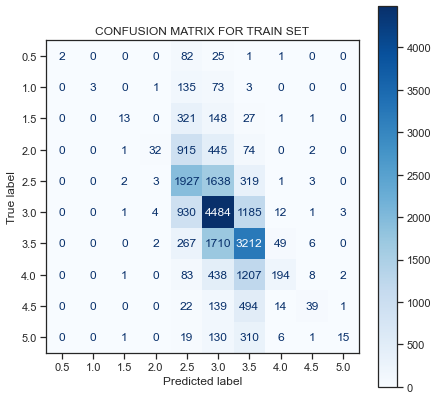

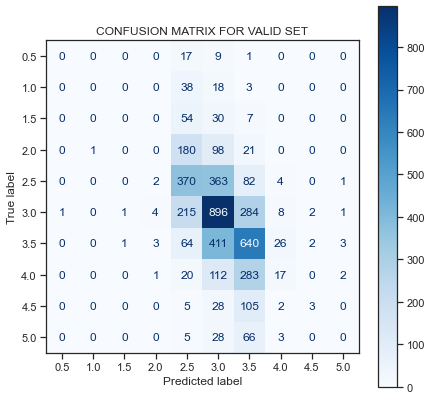

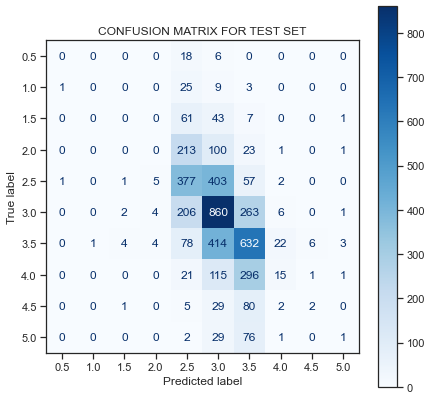

In [30]:
labels = unique_classes

featureSet     = [x_trainScaled, x_valScaled, x_testScaled]
labelSet       = [y_train, y_val, y_test]
typeOfTraining = ['TRAIN SET', 'VALID SET', 'TEST SET']


for i in range(len(featureSet)):
    y_pred = best_SVM_model.predict(featureSet[i])
    cm = confusion_matrix(labelSet[i], y_pred)

    fig, ax = plt.subplots(figsize = (7,7))

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = plt.cm.Blues, ax=ax)
    plt.title(f'CONFUSION MATRIX FOR {typeOfTraining[i]}')
    plt.show()

In [31]:
for i in range(len(featureSet)):
    y_pred = best_SVM_model.predict(featureSet[i])
    print(f'{typeOfTraining[i]} Set: \n')
    print(classification_report(labelSet[i], y_pred))

TRAIN SET Set: 

              precision    recall  f1-score   support

         0.5       1.00      0.02      0.04       111
         1.0       1.00      0.01      0.03       215
         1.5       0.68      0.03      0.05       511
         2.0       0.76      0.02      0.04      1469
         2.5       0.41      0.49      0.45      3893
         3.0       0.49      0.68      0.57      6620
         3.5       0.47      0.61      0.53      5246
         4.0       0.70      0.10      0.18      1933
         4.5       0.64      0.06      0.10       709
         5.0       0.71      0.03      0.06       482

    accuracy                           0.47     21189
   macro avg       0.69      0.21      0.20     21189
weighted avg       0.53      0.47      0.42     21189

VALID SET Set: 

              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00        27
         1.0       0.00      0.00      0.00        59
         1.5       0.00      0.00      0.00 

### III. d. Random Forests Classifier

In [32]:
depths = range(1, 31)
num_samples = [0.25, 0.5, 0.75, 1.0]
best_depth = 1
best_n_samples = num_samples[0]
best_acc = 0
best_RF_model = None

for s in num_samples:
    clf3 = RandomForestClassifier(random_state=777, max_samples=s, n_jobs=-1)
    rfModel = clf3.fit(x_trainScaled, y_train)
    y_pred_train = rfModel.predict(x_trainScaled)
    y_pred_val = rfModel.predict(x_valScaled)
    Train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    Val_acc = accuracy_score(y_true=y_val, y_pred=y_pred_val)

    if Val_acc > best_acc:
        best_acc = Val_acc
        best_n_samples = s
        best_RF_model     = rfModel

    print(f'Training accuracy: {Train_acc*100:.2f}%', end = ", ")
    print(f'Validation accuracy: {Val_acc*100:.2f}%, max samples = {s}')

best_acc = 0

for d in depths:
    clf3 = RandomForestClassifier(random_state=777, max_samples=best_n_samples, max_depth=d, n_jobs=-1)
    rfModel = clf3.fit(x_trainScaled, y_train)
    y_pred_train = rfModel.predict(x_trainScaled)
    y_pred_val = rfModel.predict(x_valScaled)
    Train_acc = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    Val_acc = accuracy_score(y_true=y_val, y_pred=y_pred_val)

    if Val_acc > best_acc:
        best_acc = Val_acc
        best_depth = d
        best_RF_model = rfModel

    if d%5==0:
        print(f'Training accuracy: {Train_acc*100:.2f}%', end = ", ")
        print(f'Validation accuracy: {Val_acc*100:.2f}%, max samples = {best_n_samples}, max depth = {d}')

print(f'\nBest Performance on Validation Set: {best_acc*100:.2f}%, max samples = {best_n_samples}, max depth = {best_depth}')

y_pred_test = best_RF_model.predict(x_testScaled)
Test_acc = accuracy_score(y_true = y_test, y_pred = y_pred_test)
print(f'\nTest accuracy of Best model: {Test_acc*100:.2f}%')

Training accuracy: 58.61%, Validation accuracy: 44.22%, max samples = 0.25
Training accuracy: 66.25%, Validation accuracy: 41.75%, max samples = 0.5
Training accuracy: 68.12%, Validation accuracy: 41.33%, max samples = 0.75
Training accuracy: 68.20%, Validation accuracy: 40.94%, max samples = 1.0
Training accuracy: 41.95%, Validation accuracy: 41.44%, max samples = 0.25, max depth = 5
Training accuracy: 46.27%, Validation accuracy: 44.77%, max samples = 0.25, max depth = 10
Training accuracy: 49.38%, Validation accuracy: 46.00%, max samples = 0.25, max depth = 15
Training accuracy: 52.50%, Validation accuracy: 46.09%, max samples = 0.25, max depth = 20
Training accuracy: 55.05%, Validation accuracy: 45.91%, max samples = 0.25, max depth = 25
Training accuracy: 56.49%, Validation accuracy: 45.56%, max samples = 0.25, max depth = 30

Best Performance on Validation Set: 46.18%, max samples = 0.25, max depth = 21

Test accuracy of Best model: 46.09%


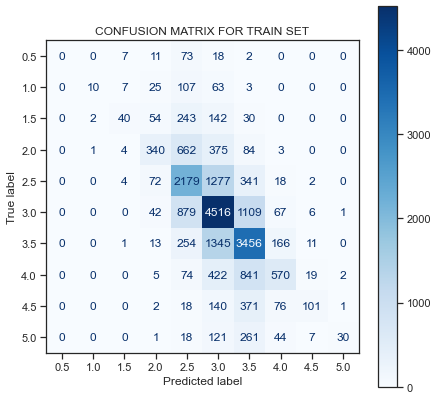

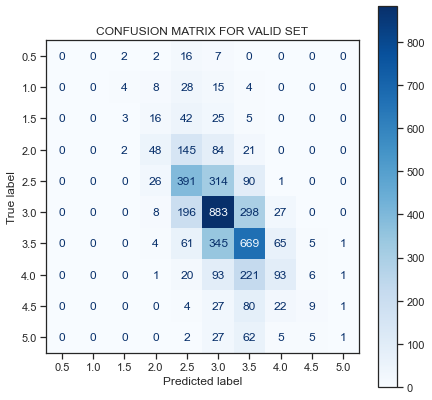

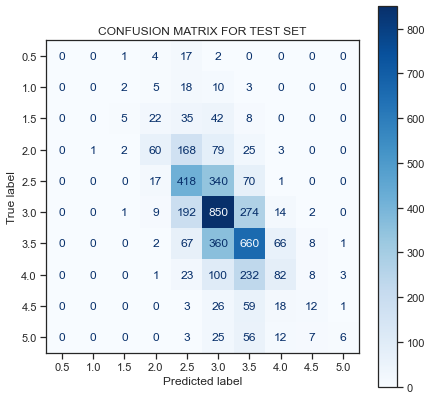

In [33]:
labels = unique_classes

featureSet     = [x_trainScaled, x_valScaled, x_testScaled]
labelSet       = [y_train, y_val, y_test]
typeOfTraining = ['TRAIN SET', 'VALID SET', 'TEST SET']


for i in range(len(featureSet)):
    y_pred = best_RF_model.predict(featureSet[i])
    cm = confusion_matrix(labelSet[i], y_pred)

    fig, ax = plt.subplots(figsize = (7,7))

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(cmap = plt.cm.Blues, ax=ax)
    plt.title(f'CONFUSION MATRIX FOR {typeOfTraining[i]}')
    plt.show()

In [34]:
for i in range(len(featureSet)):
    y_pred = best_RF_model.predict(featureSet[i])
    print(typeOfTraining[i])
    print(classification_report(labelSet[i], y_pred))

TRAIN SET
              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00       111
         1.0       0.77      0.05      0.09       215
         1.5       0.63      0.08      0.14       511
         2.0       0.60      0.23      0.33      1469
         2.5       0.48      0.56      0.52      3893
         3.0       0.54      0.68      0.60      6620
         3.5       0.53      0.66      0.59      5246
         4.0       0.60      0.29      0.40      1933
         4.5       0.69      0.14      0.24       709
         5.0       0.88      0.06      0.12       482

    accuracy                           0.53     21189
   macro avg       0.57      0.28      0.30     21189
weighted avg       0.55      0.53      0.50     21189

VALID SET
              precision    recall  f1-score   support

         0.5       0.00      0.00      0.00        27
         1.0       0.00      0.00      0.00        59
         1.5       0.27      0.03      0.06        91
    

### III. e. Expectation Maximization (Gaussian Mixture)

In [35]:
inits = range(25, 101, 25)
cov_type = ['full', 'tied', 'diag', 'spherical']
best_score = 0
best_ct    = ''
best_EM_model = None
for ct in cov_type:
    EM_model = GaussianMixture(n_components= len(unique_classes), covariance_type = ct, n_init=25, random_state = 777)
    EM_model.fit_predict(x_trainScaled)
    

    Train_score = EM_model.score(x_trainScaled)
    Val_score = EM_model.score(x_valScaled)
    print(f'Training score: {Train_score:.2f}', end = ", ")
    print(f'Validation score: {Val_score:.2f}, n_init : {50}')
    
    if Val_score>best_score:
        best_score = Val_score
        best_ct = ct
        best_EM_model = EM_model

        
print(f'\nBest Performance on Validation Set: {Val_score:.2f}')


Test_score = best_EM_model.score(x_testScaled)
print(f'\nTest score of Best model init: {Test_score:.2f}')

Training score: 75.00, Validation score: 74.81, n_init : 50
Training score: 16.69, Validation score: 16.40, n_init : 50
Training score: 74.02, Validation score: -49.56, n_init : 50
Training score: 24.24, Validation score: 23.77, n_init : 50

Best Performance on Validation Set: 23.77

Test score of Best model init: 75.59


In [36]:
# from sklearn.decomposition import PCA

In [37]:
#   pca = PCA(n_components=None,svd_solver='auto',tol=0.0,
#       iterated_power='auto', random_state=777)

In [101]:
unseen_movies = split[2].copy()
unseen_movies.drop(['movieId', 'genres', 'avg_rating'], inplace = True, axis = 1)

unseen_scaled = scaler.transform(unseen_movies)
rfPredict = best_RF_model.predict(unseen_scaled)
unseen_movies = split[2].copy()

unseen_movies['Predicted Ratings'] = rfPredict
# finalRatings = unseen_movies.sort_values(by = ['Predicted Ratings'], ascending = False)
finalRatings = pd.merge(unseen_movies, movieIdCount, left_on='movieId', right_on='movieId', how='left')
finalRatings = finalRatings.sort_values(['Predicted Ratings'], ascending = [False])

In [102]:
finalRatings.head()

,movieId,avg_rating,genres,Action,Adventure,Animation,Children,Comedy,Fantasy,IMAX,...,Mystery,Drama,Thriller,War,Horror,Film-Noir,Documentary,Musical,Predicted Ratings,tot_ratings
21081,195333,5.0,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
10850,141575,5.0,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
10055,137433,5.0,Drama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
15676,169940,5.0,Documentary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,1
3995,83161,5.0,Drama|Mystery,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1


### Generation of FINAL recommendations

- Out of the models we tested, the impressive branching and ensembling capabilities of Random Forests turned out to be the strongest classifier, and was used to predict the ratings of the movies yet to be seen by the user.
- The predictions were mapped to the dataset and had their values sorted.
- A total rating threshold was set to give a more unbiased perspective on a movie's ratings (the more ratings the more varied it is)

In [105]:
finalRecommendations = finalRatings.copy().loc[finalRatings['tot_ratings']>150][:11]
finalRecommendations.head(10)

,movieId,avg_rating,genres,Action,Adventure,Animation,Children,Comedy,Fantasy,IMAX,...,Mystery,Drama,Thriller,War,Horror,Film-Noir,Documentary,Musical,Predicted Ratings,tot_ratings
21674,198185,4.267361,Drama|Mystery,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,4.27,4.27,0.0,0.0,0.00,0.0,0.00,0.00,4.0,288
2201,27033,3.974771,Drama|Horror|Mystery,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,3.97,3.97,0.0,0.0,3.97,0.0,0.00,0.00,4.0,218
20326,191997,4.117021,Crime|Drama|Mystery,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,4.12,4.12,0.0,0.0,0.00,0.0,0.00,0.00,4.0,329
1718,6776,3.855330,Comedy|Drama|Musical|Romance,0.0,0.0,0.0,0.0,3.86,0.0,0.0,...,0.00,3.86,0.0,0.0,0.00,0.0,0.00,3.86,4.0,788
2036,8827,3.853819,Comedy|Documentary,0.0,0.0,0.0,0.0,3.85,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,3.85,0.00,4.0,1139
1617,6375,3.886139,Documentary,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,3.89,0.00,4.0,202
4369,89678,3.784211,Drama|Romance,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,3.78,0.0,0.0,0.00,0.0,0.00,0.00,4.0,190
4836,97194,3.897727,Documentary,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,3.90,0.00,4.0,176
4148,86377,3.989673,Comedy,0.0,0.0,0.0,0.0,3.99,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,4.0,1743
6609,116951,3.988764,Comedy,0.0,0.0,0.0,0.0,3.99,0.0,0.0,...,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,4.0,178
